In [68]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [135]:
# for now we will only support making a plot for one trial
# we assume the path has all static run data for the benchmark
target_path = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/bt-data/bt-smallprob-static-trial0-PA-traces'

In [136]:
# let's open all the CSV files in the given directory
csvs = list(glob.glob(target_path+'/*.csv'))

df = pd.DataFrame()
for csv in csvs:
    rawdf = pd.read_csv(csv, sep=' ')
    df = df.append(rawdf)
    
# let's only keep a few columns
df = df[['region', 'globalidx', 'policy', 'xtime']]
df = df.reset_index(drop=True)

In [137]:
# sanity check the shape
print(df.shape)
print(df.columns)

(3033, 4)
Index(['region', 'globalidx', 'policy', 'xtime'], dtype='object')


In [138]:
# let's find the optimal policy from the traces
# groupby region and globalidx
grouped = df.groupby(['region', 'globalidx'])

mins = df.loc[grouped['xtime'].idxmin()]


mins = mins.sort_values(by=['globalidx']).reset_index(drop=True)
print(mins)

# let's create the plot for this optimal policy

                              region  globalidx  policy     xtime
0     initialize.c.apollo.region.l46          0       1  0.031553
1      exact_rhs.c.apollo.region.l45          1       0  0.016323
2            rhs.c.apollo.region.l44          2       0  0.014418
3        x_solve.c.apollo.region.l71          3       0  0.021250
4        y_solve.c.apollo.region.l70          4       0  0.021563
5        z_solve.c.apollo.region.l70          5       0  0.022768
6            add.c.apollo.region.l46          6       0  0.001128
7     initialize.c.apollo.region.l46          7       0  0.005969
8            rhs.c.apollo.region.l44          8       0  0.008036
9        x_solve.c.apollo.region.l71          9       0  0.021335
10       y_solve.c.apollo.region.l70         10       0  0.021480
11       z_solve.c.apollo.region.l70         11       0  0.022701
12           add.c.apollo.region.l46         12       0  0.001127
13           rhs.c.apollo.region.l44         13       0  0.008075
14       x

In [139]:
# now that we have a cleaned up dataset, we can add some information
# to it so that we can plot it nicely. We're going to make a plot
# where the x-axis is time [0,100], and the y-axis is discrete [0,1,2,...,n]
# to represent the regions. 

# For each globalidx let's calculate the percentage of xtime they take up.
# This will allow us to find the width they consume on the plot. 
totaltime = mins['xtime'].sum()
mins['xtime_percent'] = 100*mins['xtime']/totaltime

#print(mins)

# We will also count the number of unique regions, discrtize, and map them to integers
regions = list(mins['region'].unique())
num_regions = len(regions)
print(num_regions, 'regions:', regions)
region_map = dict(zip(regions, range(num_regions)))
print(region_map)

# make the y-axis values for each datapoint
mins['y'] = mins.apply(lambda row: region_map[row.region], axis=1)

# We will also count the number of unique policies, discretize them, and map them to legend colors
policies = list(mins['policy'].unique())
num_policies = len(policies)
policies_map = dict(zip([0, 1, 2], [('red', 'policy 0'), ('green', 'policy 1'), ('blue', 'policy 2')]))

print(policies_map)

# let's make the x-axis values for each datapoint
# take the cumulative sum of all the xtime percentages
mins['x_end'] = mins['xtime_percent'].cumsum()

print(mins)
ends = np.array(mins['x_end'])
ends = np.insert(ends[0:-1], 0, 0)

mins['x_start'] = pd.Series(ends)

print(mins)


9 regions: ['initialize.c.apollo.region.l46', 'exact_rhs.c.apollo.region.l45', 'rhs.c.apollo.region.l44', 'x_solve.c.apollo.region.l71', 'y_solve.c.apollo.region.l70', 'z_solve.c.apollo.region.l70', 'add.c.apollo.region.l46', 'error.c.apollo.region.l52', 'error.c.apollo.region.l99']
{'initialize.c.apollo.region.l46': 0, 'exact_rhs.c.apollo.region.l45': 1, 'rhs.c.apollo.region.l44': 2, 'x_solve.c.apollo.region.l71': 3, 'y_solve.c.apollo.region.l70': 4, 'z_solve.c.apollo.region.l70': 5, 'add.c.apollo.region.l46': 6, 'error.c.apollo.region.l52': 7, 'error.c.apollo.region.l99': 8}
{0: ('red', 'policy 0'), 1: ('green', 'policy 1'), 2: ('blue', 'policy 2')}
                              region  globalidx  policy     xtime  \
0     initialize.c.apollo.region.l46          0       1  0.031553   
1      exact_rhs.c.apollo.region.l45          1       0  0.016323   
2            rhs.c.apollo.region.l44          2       0  0.014418   
3        x_solve.c.apollo.region.l71          3       0  0.02125

dict_keys(['initialize.c.apollo.region.l46', 'exact_rhs.c.apollo.region.l45', 'rhs.c.apollo.region.l44', 'x_solve.c.apollo.region.l71', 'y_solve.c.apollo.region.l70', 'z_solve.c.apollo.region.l70', 'add.c.apollo.region.l46', 'error.c.apollo.region.l52', 'error.c.apollo.region.l99'])


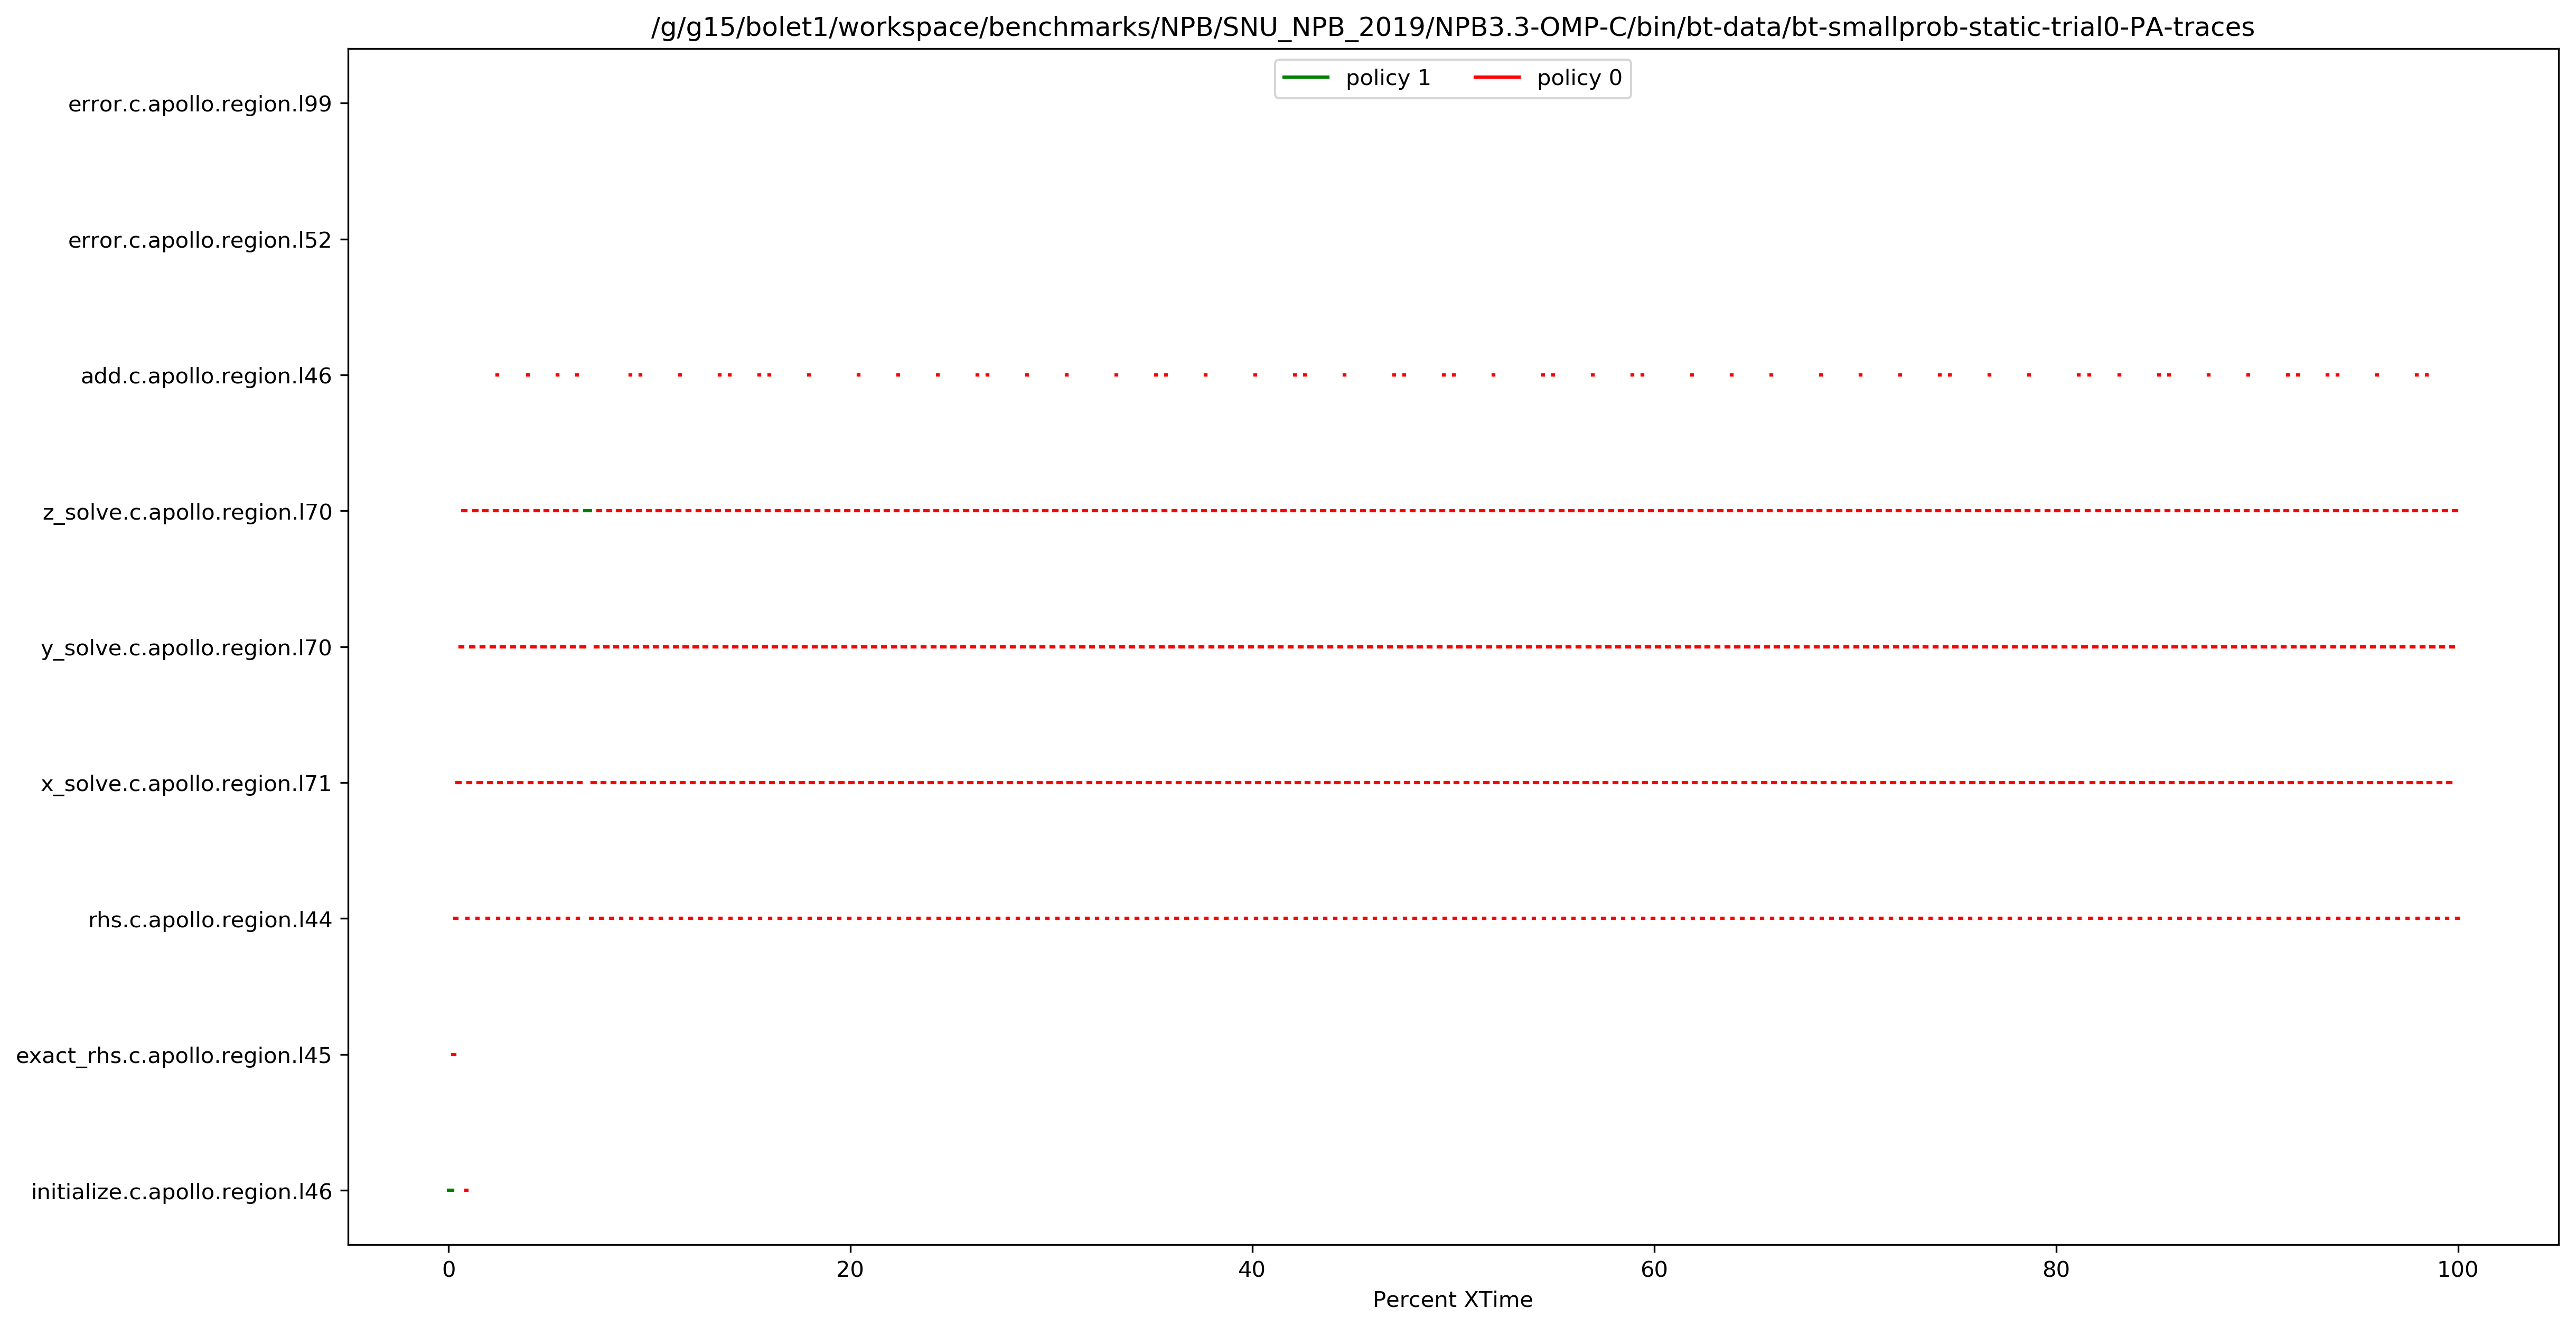

In [142]:
# Now that we have the necessary columns, let's plot the data
fig1, ax1 = plt.subplots()
fig1.set_size_inches(18, 10)
fig1.set_dpi(300)

for index, row in mins.iterrows():
    mycolor, mylabel = policies_map[row.policy]
    ax1.plot([row.x_start, row.x_end], [row.y, row.y], color=mycolor, label=mylabel)
    
print(region_map.keys())

ax1.set_title(target_path)
#ax1.set_yticklabels(regions)
ax1.set_yticks(list(region_map.values()))
ax1.set_yticklabels(list(region_map.keys()))
ax1.set_xlabel('Percent XTime')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), ncol=3, loc='upper center')